In [1]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import os.path as op
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt

from utils import qcAggregate, unstratifiedSample
from models import AggregateLearner

%matplotlib inline

### No Repeated Measures Experiment

In [2]:
bp = '../data/'
exp = '../figures/'
bpp = op.join(bp, exp)
try:
    os.makedirs(bpp)
except FileExistsError:
    pass

In [3]:
df_100 = pd.read_hdf('../data/aggregation_connect+feature+demo_dset100x1x1x20.h5')
df_100.drop(["edgecount", "globaleffic", "degree", "modularity",
             "assort", "avplength", "weight", "ccoeff", "betweenness",
             "plength", "age", "bmi", "cholesterol", "vo2max"], axis=1, inplace=True)
df_100.columns

Index(['subject', 'simulation', 'graph', 'sex'], dtype='object')

In [4]:
subs = list(df_100['subject'].unique())
for idx, row in df_100.iterrows():    
    # Replace graphs with some ID signal but a lot of common signal
    np.random.seed(row.subject + row.sex+4)
    g = 10*(np.random.random(row.graph.shape) - 0.5) + int(row.sex)*0.73
    np.random.seed(422)
    g += 20 * (np.random.random(row.graph.shape) - 0.2)
    row['graph'] = g
    del g

In [5]:
pca = PCA(n_components=20)
svc = SVC(kernel='linear', probability=True)
pipe = Pipeline(steps=[('pca', pca), ('svc', svc)])

# RS Determined as: 42, decrement until holdout was balanced by sex
rs = 41
clfmca_100 = AggregateLearner(df_100, pipe, target_id='sex',
                              observation_id='simulation',
                              sample_id='subject', data_id='graph',
                              random_seed=rs, verbose=True, triu=True)

In [6]:
%%time
clfmca_100.fit(aggregation='ref')
# clfmca_100.fit(aggregation='median')
# clfmca_100.fit(aggregation='consensus')
# clfmca_100.fit(aggregation='mean')
# clfmca_100.fit(aggregation='mega')
# clfmca_100.fit(aggregation='none')
# clfmca_100.fit(aggregation='meta')

> /Users/greg/code/gkiar/aggregate_models/code/models.py(224)_prep_data()
    222         # If flag is set, reduce connectomes to upper triangular
    223         import pdb; pdb.set_trace()
--> 224         if self.triu:
    225             triu_ind = np.triu_indices_from(X[:,:,-1], k=1)
    226             Xr = np.dstack([X[..., i][triu_ind] for i in range(X.shape[-1])])

ipdb> n
> /Users/greg/code/gkiar/aggregate_models/code/models.py(225)_prep_data()
    223         import pdb; pdb.set_trace()
    224         if self.triu:
--> 225             triu_ind = np.triu_indices_from(X[:,:,-1], k=1)
    226             Xr = np.dstack([X[..., i][triu_ind] for i in range(X.shape[-1])])
    227             Xr = np.reshape(Xr, (Xr.shape[1], Xr.shape[-1])).T

ipdb> n
> /Users/greg/code/gkiar/aggregate_models/code/models.py(226)_prep_data()
    224         if self.triu:
    225             triu_ind = np.triu_indices_from(X[:,:,-1], k=1)
--> 226             Xr = np.dstack([X[..., i][triu_ind] for i 

ipdb> c
(83, 83, 79) (79, 3403) (79,) (79,)
Training...
Y:  [2 1 1 2 2 2 1 1 2 2 1 2 1 1 1 1 2 1 1 1 2 1 2 2 1 1 1 2 1 2 1 2 2 2 1 1 2
 2 1 2 2 1 1 2 2 2 2 2 2 2 1 1 2 1 2 2 2 2 2 2 2 1 2] [2 2 2 2 2 1 1 2 1 2 1 2 2 1 2 1]
G:  [97 70 69 67 66 65 64 63 62 71 61 58 57 56 55 54 53 52 51 60 73 75 96 94
 93 92 91 90 89 88 87 85 84 83 82 81 80 79 78 77 76 50 49 72 47 18 21 46
 23 45 44 43 42 39 37 36 32 29 27 26 25 34 38] [17 16 15 13 12 11 10  8  7  4  3  2  1 22  0 24]
Accuracy:  0.875
Expl. Variance:  0.47982276400954327
Training...
Y:  [2 1 1 2 2 2 1 1 2 2 1 2 1 1 1 1 2 1 1 2 1 2 2 1 1 1 2 1 2 1 2 2 2 1 1 2 2
 1 2 2 2 2 2 2 2 2 2 1 1 2 1 2 1 2 2 1 2 2 2 2 2 1 2] [1 1 1 2 2 2 1 1 1 2 2 2 2 2 2 1]
G:  [97 70 69 67 66 65 64 63 62 71 61 58 57 56 55 54 53 52 60 73 75 96 94 93
 92 91 90 89 88 87 85 84 83 82 81 80 79 78 77 76 72 47 17 16 15 13 12 11
 10  8  7  4  3  2  1 22  0 46 45 42 37 24 38] [51 50 49 18 21 23 44 43 39 36 32 29 27 26 25 34]
Accuracy:  0.8125
Expl. Variance:  0.4659732117831

In [8]:
clfmca_100.perf

{'ref': {'true': [array([2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1]),
   array([1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1]),
   array([2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2]),
   array([1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 1, 2, 2, 2]),
   array([2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 1, 2])],
  'pred': [array([2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2]),
   array([1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1]),
   array([1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 2, 2]),
   array([1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2]),
   array([2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 1, 1])],
  'acc': [0.875, 0.8125, 0.875, 0.9375, 0.9333333333333333],
  'f1': [0.8,
   0.7692307692307692,
   0.8750000000000001,
   0.923076923076923,
   0.923076923076923],
  'expvar': [0.47982276400954327,
   0.4659732117831963,
   0.4641962542528219,
   0.4787612283465752,
   0.4735424354144964]}}

In [7]:
clfmca_100.performance_report()

,aggregation,acc,f1,test_acc,test_f1,test_mean_acc,test_mean_f1,n_models
0,ref,0.886667,0.858077,0.736842,0.615385,0.736842,0.624908,5


In [7]:
from utils import refSample

(83, 83)
Original shape:  (83, 83, 2057)
Aggregation shape:  (83, 83)


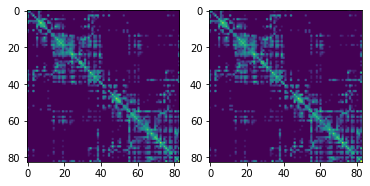

In [9]:
g = df_100.graph.values[0]
print(g.shape)
qcAggregate(np.dstack(df_100.graph.values), g)


In [29]:
np.array_equal(np.triu(g, k=1) + np.tril(g, k=0), g)

True

In [25]:
newg = g[np.triu_indices(g)]

Original shape:  (83, 83, 2057)
Aggregation shape:  (3486,)


TypeError: Invalid shape (3486,) for image data

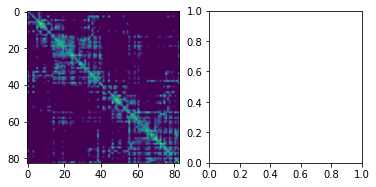

In [26]:
qcAggregate(np.dstack(df_100.graph.values), newg)


### Repeated Measures Experiment

In [5]:
df_25 = pd.read_hdf('../data/aggregation_connect+demo_dset25x2x2x20.h5')
df_25.drop(["age", "bmi", "cholesterol", "vo2max"], axis=1, inplace=True)
df_25.columns

Index(['subsample', 'graph', 'session', 'simulation', 'subject', 'sex'], dtype='object')

In [11]:
subs = list(df_25['subject'].unique())

np.random.seed(1234567890)
for idx, row in df_25.iterrows():
    # Replace subids with unique numbers
    loc = subs.index(row.subject)
    row['subject'] = loc
    del loc
    
    row['sex'] = int(row['sex'])
    
    # Replace graphs with some ID signal but a lot of common signal
#     np.random.seed(row.subject*(row.session+1) + row.sex + 4)
    g = 10*(np.random.random(row.graph.shape) - 0.5) + int(row.sex)*0.7
#     np.random.seed(422)
    g += 20 * (np.random.random(row.graph.shape) - 0.2)
    row['graph'] = g
    del g

In [12]:
df_25mca = df_25.query('subsample == 0 and session == 0')
print(len(df_25mca))

df_25sub = df_25.query('simulation == "ref" and session == 0')
print(len(df_25sub))

df_25ses = df_25.query('simulation == "ref" and subsample == 0')
print(len(df_25ses))

525
50
50


In [48]:
pca = PCA(n_components=10)
svc = SVC(kernel='linear', probability=True)
pipe = Pipeline(steps=[('pca', pca), ('svc', svc)])

# RS Determined as: 42, increment until holdout was balanced by sex
rs = 45
clfmca_25 = AggregateLearner(df_25ses, pipe, target_id='sex',
                             observation_id='simulation',
                             sample_id='subject', data_id='graph',
                             random_seed=rs, verbose=False, oos=0.3,
                             cvfolds=7)

In [49]:
clfmca_25.fit(aggregation='ref')
# clfmca_25.fit(aggregation='median')
# clfmca_25.fit(aggregation='consensus')
clfmca_25.fit(aggregation='mean')
clfmca_25.fit(aggregation='mega')
# clfmca_25.fit(aggregation='none')
# clfmca_25.fit(aggregation='meta')

In [50]:
clfmca_25.performance_report()

,aggregation,acc,f1,test_acc,test_f1,test_mean_acc,test_mean_f1,n_models
0,ref,0.571429,0.701020,0.714286,0.833333,0.806122,0.884502,7
1,mean,0.690476,0.690476,0.857143,0.909091,0.877551,0.920635,7
2,mega,0.571429,0.701020,0.714286,0.833333,0.806122,0.884502,7


In [56]:
pca = PCA(n_components=10)
lrc = LogisticRegression(solver='liblinear')
pipe = Pipeline(steps=[('pca', pca), ('lrc', lrc)])

# RS Determined as: 42, increment until holdout was balanced by sex
rs = 45
clfmca_25 = AggregateLearner(df_25sub, pipe, target_id='sex',
                             observation_id='simulation',
                             sample_id='subject', data_id='graph',
                             random_seed=rs, verbose=False, oos=0.3,
                             cvfolds=7)

In [57]:
clfmca_25.fit(aggregation='ref')
# clfmca_25.fit(aggregation='median')
# clfmca_25.fit(aggregation='consensus')
clfmca_25.fit(aggregation='mean')
clfmca_25.fit(aggregation='mega')
# clfmca_25.fit(aggregation='none')
# clfmca_25.fit(aggregation='meta')

In [58]:
clfmca_25.performance_report()

,aggregation,acc,f1,test_acc,test_f1,test_mean_acc,test_mean_f1,n_models
0,ref,0.97619,0.979592,0.928571,0.952381,0.836735,0.880409,7
1,mean,1.00000,1.000000,0.857143,0.909091,0.897959,0.935065,7
2,mega,0.97619,0.979592,0.928571,0.952381,0.836735,0.880409,7


In [113]:
pca = PCA(n_components=13)
rfc = RandomForestClassifier()
pipe = Pipeline(steps=[('pca', pca), ('rfc', rfc)])

# RS Determined as: 42, increment until holdout was balanced by sex
rs = 43
clfmca_25 = AggregateLearner(df_25mca, pipe, target_id='sex',
                             observation_id='simulation',
                             sample_id='subject', data_id='graph',
                             random_seed=rs, verbose=False, oos=0.2,
                             cvfolds=5)

In [114]:
clfmca_25.fit(aggregation='ref')
# clfmca_25.fit(aggregation='median')
# clfmca_25.fit(aggregation='consensus')
clfmca_25.fit(aggregation='mean')
clfmca_25.fit(aggregation='mega')
# clfmca_25.fit(aggregation='none')
# clfmca_25.fit(aggregation='meta')

In [115]:
clfmca_25.performance_report()

,aggregation,acc,f1,test_acc,test_f1,test_mean_acc,test_mean_f1,n_models
0,ref,0.650000,0.780952,0.40000,0.571429,0.400000,0.571429,5
1,mean,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,5
2,mega,0.964286,0.969041,0.92381,0.913043,0.912381,0.906728,5


In [116]:
for est in clfmca_25.clf['ref'].estimators_:
    print(np.sum(est.steps[0][1].explained_variance_ratio_))

0.8754412941261775
0.8754285015026906
0.8753186298853655
0.8749374253297413
0.8748739278555181
